# Stellar population fit by ppxf

## Import relevant modules

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from os.path import basename
from copy import copy
import shutil

from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib

# Other dependencies
from der_snr import DER_SNR
from ned import NedCalculator

## Create necessary functions

In [116]:
def bootstrap_residuals(model, resid, wild=True):
    """
    https://en.wikipedia.org/wiki/Bootstrapping_(statistics)#Resampling_residuals
    https://en.wikipedia.org/wiki/Bootstrapping_(statistics)#Wild_bootstrap

    Davidson & Flachaire (2008) eq.(12) gives the recommended form
    of the wild bootstrapping probability used here.

    https://doi.org/10.1016/j.jeconom.2008.08.003

    :param spec: model (e.g. best fitting spectrum)
    :param res: residuals (best_fit - observed)
    :param wild: use wild bootstrap to allow for variable errors
    :return: new model with bootstrapped residuals

    """
    if wild:    # Wild Bootstrapping: generates -resid or resid with prob=1/2
        eps = resid*(2*np.random.randint(2, size=resid.size) - 1)
    else:       # Standard Bootstrapping: random selection with repetition
        eps = np.random.choice(resid, size=resid.size)

    return model + eps

In [117]:
def read_fits_summary(fitsfile):
    
    hdu = fits.open(fitsfile)
    
    age_grid = hdu['age_grid'].data
    weights = hdu['pp_weights'].data.reshape(hdu['reg_dim'].data)
    
    name = hdu[0].header['name']
    z = hdu[0].header['z']
    hdu.close()
    del hdu
    
    wei1 = weights.sum(axis=1)
    wei1/=wei1.sum()
    
    wei1_rev = copy(wei1[::-1])
    
    ages = age_grid[:,0]
    ages1 = (ages[-1]-ages)[::-1]+(ages[1]-ages[0])
    
    agesplot = np.concatenate([np.array([0.]),ages1])
    weiplot = np.concatenate([np.array([0.]),np.cumsum(wei1_rev)])
    
    agesplot = np.concatenate([agesplot,np.array([agesplot[-1]+(agesplot[-1]-agesplot[-2])])])
    weiplot = np.concatenate([weiplot,np.array([weiplot[-1]])])
    
    # nedcalc = NedCalculator([z])
    nedcalc = NedCalculator(z)
    univ_age = nedcalc.zage_Gyr
    
    agesplot = [a if a<univ_age else univ_age for a in agesplot]
    
    return name,z,agesplot,weiplot,univ_age


In [118]:
def plot_sfh(ax,fitsfile,col_line,legend_on=False):
    name,z,agesplot,weiplot,univ_age = read_fits_summary(fitsfile)

    ax.set_title(name,fontsize=18,weight='bold')
    ax.set_xlim(0,13.5)
    ax.set_ylim(-0.05,1.05)
    ax.set_xlabel('Time since BB (Gyr)',fontsize=15)
    ax.set_ylabel('Cumulative mass %',fontsize=15)
    ax.minorticks_on()
    ax.tick_params(axis='both',which='both',direction='in',labelsize=15)
    
    ax.axhline(0.75,color='gray',alpha=0.2)
    ax.text(12,0.76,'75%',style='italic',color='gray')
    ax.axhline(0.95,color='gray',alpha=0.2)
    ax.text(12,0.96,'95%',style='italic',color='gray')
    ax.axvline(3.,color='gray',alpha=0.2,linestyle='-.',linewidth=2.)
    ax.axvline(univ_age,color='gray',linestyle='-.',linewidth=2.)
    
    ax.plot(agesplot,weiplot,color=col_line,linewidth=3.)
    
    ax.text(univ_age-0.1,0.,'today',color='gray',style='italic',rotation=90,horizontalalignment='right')
    ax.text(2.9,0.,'z~2',style='italic',color='gray',rotation=90,horizontalalignment='right')
    ax.set_xticks([0.,2.,4.,6.,8.,10.,12.])
    
    if legend_on==True:
        ax.legend(frameon=False,bbox_to_anchor=(univ_age/ax.get_xlim()[1], -0.05),loc='lower right',prop={'size':12,'weight':'bold'},labelspacing=0.1,labelcolor='linecolor')
        
    return agesplot,weiplot

In [119]:
def line2p(p1,p2,x):
    
    x1,y1 = p1
    x2,y2 = p2
    
    m = (y2-y1)/(x2-x1)
    q = -(y2-y1)/(x2-x1)*x1+y1
    
    return m*x+q

def line2p_rev(p1,p2,y):
    
    x1,y1 = p1
    x2,y2 = p2
    
    return (y-y1)/(y2-y1)*(x2-x1)+x1 if y2!=y1 else x2
    
def get_values_from_sfh(univ_age,sfh_table,ycol):
    '''
    INPUTS:
        univ_age: the age of the universe at the redshift of the galaxy in Gyr
        sfh_table: the plotted sfh in the form of a pandas DataFrame. It needs to have a column named "time"
        ycol: is the name of the column of the sfh_table we want to use in order to retrieve the different values we want to compute
    
    OUTPUTS:
        y_z2: mass formed at redshift~2
        x_075: time to form 75% of the mass (t_75)
        x_090: time to form 90% of the mass (t_90)
        x_100: time to form 100% of the mass (t_fin)
        dor_90: Degree of Relicness using x_090
        dor_100: : Degree of Relicness using x_100
    '''
    
    tt = []
    tt90 = []
    tt100 = []
    
    ii=0
    while sfh_table.iloc[ii][ycol]<0.75:
        tt.append((ii,sfh_table.iloc[ii][ycol]))
        ii+=1
    tt.append((ii,sfh_table.iloc[ii][ycol]))
    
    yy = sfh_table.iloc[np.array(tt[-2:])[:,0]]
    
    xx = line2p_rev(yy[['time',ycol]].iloc[0].values,yy[['time',ycol]].iloc[1].values,0.75)
    
    ii=0
    while sfh_table.iloc[ii][ycol]<0.9 :
        tt90.append((ii,sfh_table.iloc[ii][ycol]))
        ii+=1
    tt90.append((ii,sfh_table.iloc[ii][ycol]))
    
    yy90 = sfh_table.iloc[np.array(tt90[-2:])[:,0]]
    
    xx90 =  line2p_rev(yy90[['time',ycol]].iloc[0].values,yy90[['time',ycol]].iloc[1].values,0.9)
    
    ii=0
    while sfh_table.iloc[ii][ycol]<0.998 :
        tt100.append((ii,sfh_table.iloc[ii][ycol]))
        ii+=1
    tt100.append((ii,sfh_table.iloc[ii][ycol]))
    
    yy100 = sfh_table.iloc[np.array(tt100[-2:])[:,0]]
    
    xx100 =  line2p_rev(yy100[['time',ycol]].iloc[0].values,yy100[['time',ycol]].iloc[1].values,0.998)
    
    tt_rev = [(0,0)]
    
    for i in range(1,len(sfh_table['time'])):
        
        p1 = sfh_table['time'].iloc[i-1],sfh_table[ycol].iloc[i-1]
        p2 = sfh_table['time'].iloc[i],sfh_table[ycol].iloc[i]
        
        xs = np.arange(sfh_table['time'].iloc[i-1],sfh_table['time'].iloc[i]+0.1,0.1)
        ys = line2p(p1,p2,xs)

                
        for x,y in zip(xs,ys):
            tt_rev.append((round(x,2),y))


    tt_rev = np.array(tt_rev)

    # this is the mass formed at redshift ~2
    y_z2 = round(tt_rev[:,1][np.where(tt_rev[:,0]==2.90)[0]][0],5)
    
    # these are the times at 75%, 90%, and 100% formed mass
    x_075 = round(xx,5)
    x_090 = round(xx90,5)
    x_100 = round(xx100,5)
    
    dor_90 = (y_z2+0.5/x_075+(0.7+(univ_age-x_090)/univ_age))/3
    dor_100 = (y_z2+0.5/x_075+(0.7+(univ_age-x_100)/univ_age))/3
    
    
    
    return y_z2,x_075,x_090,x_100,dor_90,dor_100

## Load in the shortlist csv

In [120]:
# The catalogue with all the galaxies
# df_dor = pd.read_csv('/Users/johnmills/Summer project/DoR_fit/ppxf_stel_pop_dor_test.csv')
# df_dor = pd.read_csv("data/E-INSPIRE_I_master_catalogue.csv")
# df_dor.head()

# make output directories if they dont exist
directories = ['ppxf_fits_test2', 'sfh_plots_test2', 'stacked_catalogues']
for directory in directories:
        if not os.path.exists(directory):
            os.makedirs(directory)

    
clustering_methods = {
    'DoR': ['DoR_0', 'DoR_1', 'DoR_2'],
    'KMeans': ['KMeans_0', 'KMeans_1', 'KMeans_2'],
    'GMM': ['GMM_0', 'GMM_1', 'GMM_2'],
    'Hierarchical': ['Hierarchical_0', 'Hierarchical_1', 'Hierarchical_2']
}

file_names = []
method = 'DoR' # change for each method!
files_list = clustering_methods[method]
for file in files_list:
    file = "stacked_fits/stacked_"+file+".fits"
    file_names.append(file)

## Iterate over each row to fit the stellar population of each object

In [121]:
tie_balmer = True
limit_doublets = True

c = 299792.458  # speed of light in km/s

regul_err = 0.1 # Large regularization error

vel = 0   # eq.(8) of Cappellari (2017)

moments = [4, 2, 2]

gas_reddening = 0 if tie_balmer else None

logAges = []
metals = []
snrs = []




nrand = 2
# nrand = 9







col_line1 = 'black' # gdago: here you choose the color of the line        
col_line2 = 'green' # gdago: here you choose the color of the line

# Some lists to add into the catalogue later
mass_fracs = []
times_75 = []
times_90 = []
times_100 = []
dors_100 = []
univ_ages = []

mass_fracsu = []
times_75u = []
times_90u = []
times_100u = []
dors_100u = []

mass_fracsr = []
times_75r = []
times_90r = []
times_100r = []
dors_100r = []

[1092.1147079476093]
Emission lines included in gas templates:
['Balmer' '[OII]3726_d1' '[OII]3726_d2' '[NeIII]3968' '[NeIII]3869'
 'HeII4687' 'HeI5876' '[OIII]5007_d' '[OI]6300_d']


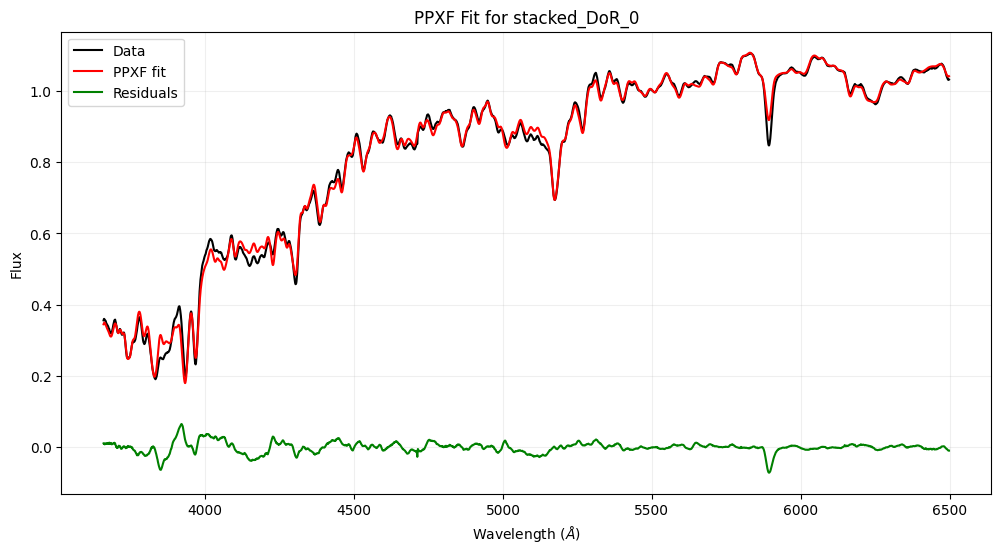

DoR cluster 0 done
[1092.1147079476093, 3083.023262647888]
Emission lines included in gas templates:
['Balmer' '[OII]3726_d1' '[OII]3726_d2' '[NeIII]3968' '[NeIII]3869'
 'HeII4687' 'HeI5876' '[OIII]5007_d' '[OI]6300_d']


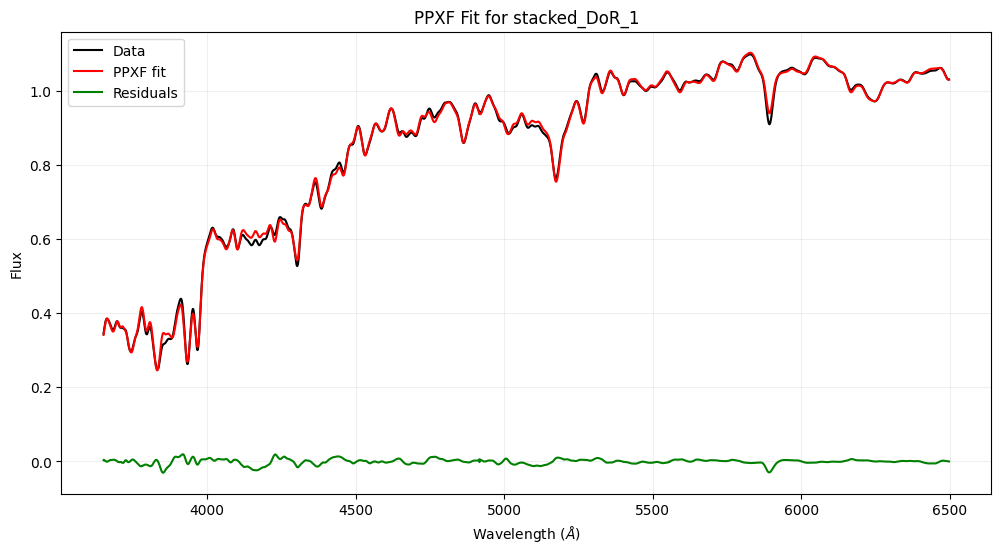

DoR cluster 1 done
[1092.1147079476093, 3083.023262647888, 808.968025923069]
Emission lines included in gas templates:
['Balmer' '[OII]3726_d1' '[OII]3726_d2' '[NeIII]3968' '[NeIII]3869'
 'HeII4687' 'HeI5876' '[OIII]5007_d' '[OI]6300_d']


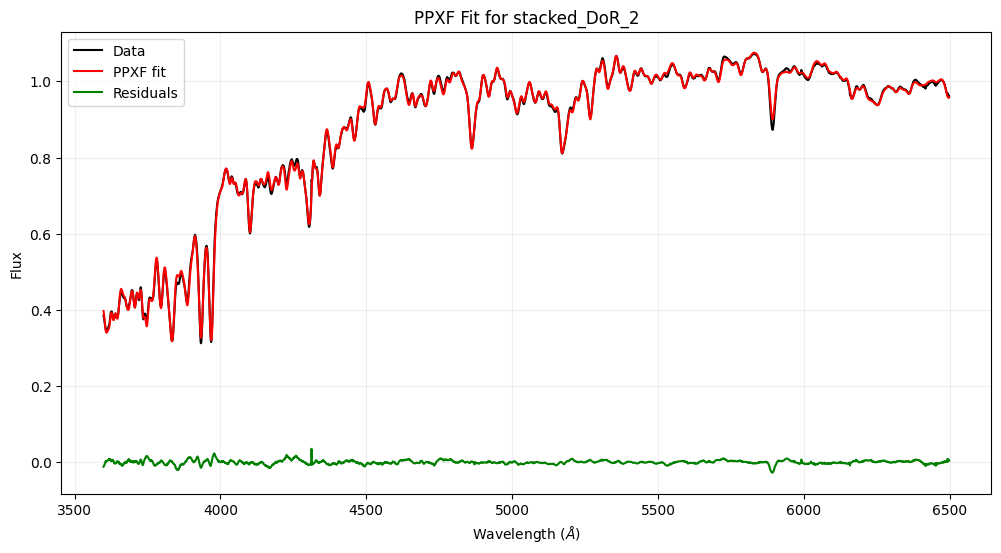

DoR cluster 2 done


In [122]:
# Loop over all the galaxies in the catalogue
# for index, row in df_dor.iterrows():

for i, filename in enumerate(file_names):
    hdu = fits.open(filename, ignore_missing_simple=True)
    
    t = hdu['COADD'].data
    galaxy = t['flux']
    wave = t['wave']
    
    galaxy = galaxy[(wave > 3600) & (wave < 6500)]
    wave = wave[(wave > 3600) & (wave < 6500)]
    
    sigma = t['sigma'][0]
    alpha = t['ALPHA'][0]  
    # array of the average alpha (repeated many times for formatting sake)
    # SWAP OUT FOR WHATEVER JOHN CALCULATES!!!
    
    redshift = 0
    
    if alpha < 0:
        alpha = '0'
    elif alpha > 0.4:
        alpha = '4'
    else:
        alpha = str(int(alpha*10))

    # wave = wave/(1 + redshift)  # Compute wave in the galaxy rest frame
    # Restrict wavelength range
    # galaxy = galaxy[(wave > 3600) & (wave < 6500)]
    # wave = wave[(wave > 3600) & (wave < 6500)]

    snr = DER_SNR(galaxy) # Compute SNR
    snrs.append(snr)
    print(snrs)
    wave *= np.median(util.vac_to_air(wave)/wave)

    noise = np.full_like(galaxy, 0.0163)  # Assume constant noise per pixel here

    d_ln_lam = np.log(wave[-1]/wave[0])/(wave.size - 1)  # Average ln_lam step
    velscale = c*d_ln_lam                   # eq. (8) of Cappellari (2017)
    FWHM_gal = 2.76/(1+redshift)  # SDSS has an approximate instrumental resolution FWHM of 2.76A.
    
    # Load the SSP models 
    ssp_file = f'MILES_SSP/alpha{alpha}.npz'
    sps = lib.sps_lib(ssp_file, velscale, FWHM_gal, age_range=[0, NedCalculator(redshift).zage_Gyr], metal_range=[-2, 0.5])

    reg_dim = sps.templates.shape[1:]
    stars_templates = sps.templates.reshape(sps.templates.shape[0], -1)

    lam_range_gal = np.array([np.min(wave), np.max(wave)])

    gas_templates, gas_names, line_wave = util.emission_lines(
        sps.ln_lam_temp, lam_range_gal, FWHM_gal, tie_balmer=tie_balmer,
        limit_doublets=limit_doublets)
    
    templates = np.column_stack([stars_templates, gas_templates])

    # start = [vel, sigma]     # (km/s), starting guess for [V, sigma]
    start = [vel, sigma]
 
    n_temps = stars_templates.shape[1]
    n_forbidden = np.sum(["[" in a for a in gas_names])  # forbidden lines contain "[*]"
    n_balmer = len(gas_names) - n_forbidden

    component = [0]*n_temps + [1]*n_balmer + [2]*n_forbidden
    gas_component = np.array(component) > 0  # gas_component=True for gas templates

    start = [start, start, start]

    # First run is just to compute a good estimate of the noise (it isn't used in the final fit)
    pp = ppxf(templates, galaxy, noise, velscale, start, moments=moments,
            degree=-1, mdegree=8, lam=wave, lam_temp=sps.lam_temp,
            regul=1/regul_err, reg_dim=reg_dim, component=component,
            gas_component=gas_component, gas_names=gas_names,
            gas_reddening=gas_reddening, quiet=True)

    noise = noise*np.sqrt(pp.chi2)

    pp = ppxf(templates, galaxy, noise, velscale, start, moments=moments,
                degree=-1, mdegree=8, lam=wave, lam_temp=sps.lam_temp,
                regul=1/regul_err, reg_dim=reg_dim, component=component,
                gas_component=gas_component, gas_names=gas_names,
                gas_reddening=gas_reddening, clean=True, quiet=True)
    
    weights = pp.weights[~gas_component]                # Exclude weights of the gas templates
    weights = weights.reshape(reg_dim)/weights.sum()    # Normalized

    mean_age = sps.mean_age_metal(weights, quiet=True)

    hdu_wei = fits.ImageHDU(data=weights,name='pp_weights') # save the grid before reshaping the weights
    hdu_regdim = fits.ImageHDU(data=reg_dim,name='reg_dim')
    hdu_age = fits.ImageHDU(data=sps.age_grid,name='age_grid')
    hdu_metal = fits.ImageHDU(data=sps.metal_grid,name='metal_grid')
    bestfit = fits.ImageHDU(data=pp.bestfit,name='bestfit_spectrum')
    lam = fits.ImageHDU(data=wave,name='wavelength')
    orig = fits.ImageHDU(data=galaxy,name='original_spectrum')
    gas = fits.ImageHDU(data=pp.gas_bestfit,name='gas_bestfit')

    #Store the results in a way that is suitable for Peppe's SFH plotting
    
    #name = row['sexa_id'] #This is just the ID
    name = filename.replace('stacked_fits/','').replace('.fits','')
    z_orig = redshift # This should be the original redshift of each galaxy
    # Write outputs in fits files
    hdr = fits.Header()
    #hdr['HIERARCH SDSS_ID'] = row['objid']
    hdr['HIERARCH NAME'] = name
    hdr['HIERARCH z'] = z_orig
    hdr['HIERARCH mean_age_unr'] = mean_age[0]
    hdr['HIERARCH mean_metal_unr'] = mean_age[1]
    hdr['HIERARCH Mg/Fe'] = alpha           
    #hdr['HIERARCH velDisp'] = row['velDisp_ppxf']
    hdr['HIERARCH SNR'] = snr
    primary_hdu = fits.PrimaryHDU(header=hdr)
    hdulist = [primary_hdu, hdu_wei, hdu_regdim, hdu_age, hdu_metal, bestfit, lam, orig, gas]
    hdulis = fits.HDUList(hdulist)
    savepath = './ppxf_fits_test2/'
    if not os.path.exists(savepath):
        os.makedirs(savepath)
     
    hdulis.writeto(savepath+name+'_ppxfout_UNR.fits',overwrite=True)


    # Bootstrapping
    bestfit0 = pp.bestfit.copy()
    resid = galaxy - bestfit0
    start = pp.sol.copy()

    np.random.seed(123)

    weights_array = np.empty((nrand, pp.weights.size))
    for j in range(nrand):

        galaxy1 = bootstrap_residuals(bestfit0, resid)

        pp = ppxf(templates, galaxy1, noise, velscale, start, moments=moments,
                degree=-1, mdegree=8, lam=wave, lam_temp=sps.lam_temp,
                component=component,
                gas_component=gas_component, gas_names=gas_names,
                gas_reddening=gas_reddening, quiet=True)

        noise = noise*np.sqrt(pp.chi2)

        pp = ppxf(templates, galaxy1, noise, velscale, start, moments=moments,
                degree=-1, mdegree=8, lam=wave, lam_temp=sps.lam_temp,
                component=component,
                gas_component=gas_component, gas_names=gas_names,
                gas_reddening=gas_reddening, clean=True, quiet=True)

        weights_array[j] = pp.weights

        weights = pp.weights[~gas_component]                # Exclude weights of the gas templates
        weights = weights.reshape(reg_dim)/weights.sum()    # Normalized

    plt.figure(figsize=(12,6))
    plt.plot(wave, galaxy, 'k-', label='Data')  # Original data in black
    plt.plot(wave, pp.bestfit, 'r-', label='PPXF fit')  # Best fit in red
    plt.plot(wave, galaxy - pp.bestfit, 'g-', label='Residuals')  # Residuals in green
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.title(f'PPXF Fit for {name}')
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()
    
    pp.weights = weights_array.sum(0)
    weights_err = weights_array.std(0)

    weights = pp.weights[~gas_component]  # E+fxclude weights of the gas templates
    weights = weights.reshape(reg_dim)/weights.sum()  # Normalized
    
    mean_age = sps.mean_age_metal(weights, quiet=True)
    sps.mean_age_metal(weights, quiet=True);
    logAges.append(mean_age[0])
    metals.append(mean_age[1])

    hdu_wei = fits.ImageHDU(data=weights,name='pp_weights') # save the grid before reshaping the weights
    hdu_regdim = fits.ImageHDU(data=reg_dim,name='reg_dim')
    hdu_age = fits.ImageHDU(data=sps.age_grid,name='age_grid')
    hdu_metal = fits.ImageHDU(data=sps.metal_grid,name='metal_grid')
    bestfit = fits.ImageHDU(data=pp.bestfit,name='bestfit_spectrum')
    lam = fits.ImageHDU(data=wave,name='wavelength')
    orig = fits.ImageHDU(data=galaxy,name='original_spectrum')
    gas = fits.ImageHDU(data=pp.gas_bestfit,name='gas_bestfit')

    # Write outputs in fits files
    hdr = fits.Header()
    #hdr['HIERARCH SDSS_ID'] = row['objid']
    hdr['HIERARCH NAME'] = name
    hdr['HIERARCH z'] = z_orig
    hdr['HIERARCH mean_age_unr'] = mean_age[0]
    hdr['HIERARCH mean_metal_unr'] = mean_age[1]
    hdr['HIERARCH Mg/Fe'] = alpha
    #hdr['HIERARCH velDisp'] = row['velDisp_ppxf']
    hdr['HIERARCH SNR'] = snr
    primary_hdu = fits.PrimaryHDU(header=hdr)
    hdulist = [primary_hdu, hdu_wei, hdu_regdim, hdu_age, hdu_metal, bestfit, lam, orig, gas]
    hdulis = fits.HDUList(hdulist)
    hdulis.writeto(savepath+name+'_ppxfout_REGUL.fits',overwrite=True)





    ## Plotting SFHs for each galaxy (but this section not needed for fitting stel pop parameters)

    plt.figure(figsize=(6,4))
    ax1 = plt.subplot(1,1,1)

    ppxfout_file_unr = savepath + name + '_ppxfout_UNR.fits'
    ppxfout_file = savepath + name + '_ppxfout_REGUL.fits'

    agesplot,weiplot = plot_sfh(ax1,ppxfout_file_unr,col_line1,legend_on=False) 
    agesplot,weiplot = plot_sfh(ax1,ppxfout_file,col_line2,legend_on=False)

    savepath = './sfh_plots_test2/'
    if not os.path.exists(savepath):
        os.makedirs(savepath)
  
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1)
    plt.savefig(savepath+basename(ppxfout_file).replace('.fits','.pdf'),dpi=120)
    plt.close()

    ## Computing DoR values (also not needed for fitting stel pop parameters)

    name1,z1,agesplot1,weiplot1,univ_age1 = read_fits_summary(ppxfout_file_unr)
    name2,z2,agesplot2,weiplot2,univ_age2 = read_fits_summary(ppxfout_file)
    df_out = pd.DataFrame({'time':agesplot1, 'regul0':weiplot1, 'regul_max':weiplot2})
    y_z2u,x_075u,x_090u,x_100u,dor_90u,dor_100u = get_values_from_sfh(univ_age1,df_out,"regul0")
    y_z2r,x_075r,x_090r,x_100r,dor_90r,dor_100r = get_values_from_sfh(univ_age2,df_out,"regul_max")

    mass_fracsu.append(y_z2u)
    times_75u.append(x_075u)
    times_90u.append(x_090u)
    times_100u.append(x_100u)
    dors_100u.append(dor_100u)

    mass_fracsr.append(y_z2r)
    times_75r.append(x_075r)
    times_90r.append(x_090r)
    times_100r.append(x_100r)
    dors_100r.append(dor_100r)

    y_z2 = min(y_z2u,y_z2r)
    x_075 = max(x_075u,x_075r)
    x_090 = max(x_090u,x_090r)
    x_100 = max(x_100u,x_100r)
    dor_100 = (y_z2+0.5/x_075+(0.7+(univ_age1-x_100))/univ_age1)/3

    mass_fracs.append(y_z2)
    times_75.append(x_075)
    times_90.append(x_090)
    times_100.append(x_100)
    dors_100.append(dor_100)
    univ_ages.append(univ_age1)
        
    print(f'{method} cluster {i} done')

## Save everything

In [123]:
df_dor = pd.DataFrame()
df_dor['logAge'] = logAges
df_dor['[M/H]'] = metals
df_dor['SNR'] = snrs

df_dor['mass_frac'] = mass_fracs
df_dor['time_75'] = times_75
df_dor['time_90'] = times_90
df_dor['time_100'] = times_100
df_dor['dor_100'] = dors_100
df_dor['univ_age'] = univ_ages
   
df_dor['mass_frac_reg'] = mass_fracsr
df_dor['time_75_reg'] = times_75r
df_dor['time_90_reg'] = times_90r
df_dor['time_100_reg'] = times_100r
df_dor['dor_100_reg'] = dors_100r

df_dor['mass_frac_unr'] = mass_fracsu
df_dor['time_75_unr'] = times_75u
df_dor['time_90_unr'] = times_90u
df_dor['time_100_unr'] = times_100u
df_dor['dor_100_unr'] = dors_100u

df_dor.head()

,logAge,[M/H],SNR,mass_frac,time_75,time_90,time_100,dor_100,univ_age,mass_frac_reg,time_75_reg,time_90_reg,time_100_reg,dor_100_reg,mass_frac_unr,time_75_unr,time_90_unr,time_100_unr,dor_100_unr
0,10.080115,0.346019,1092.114708,0.94315,0.82912,1.13965,3.48241,0.774919,12.565039,0.94315,0.82912,0.96182,3.48241,0.989683,1.00000,0.82026,1.13965,1.90643,1.052613
1,10.057184,0.301254,3083.023263,0.98040,2.08383,2.33825,12.23949,0.433987,12.565039,0.99536,2.08383,2.33825,12.17359,0.655486,0.98040,1.31858,1.98483,12.23949,0.695168
2,9.854237,0.214690,808.968026,0.59696,4.74133,11.30415,12.34617,0.258515,12.565039,0.59696,4.74133,11.25911,12.34617,0.473278,0.67039,3.72330,11.30415,11.97461,0.517223


In [124]:
df_dor.to_csv(f'stacked_catalogues/CATALOGUE_{method}.csv', index=False)

In [125]:
raise KeyboardInterrupt
# just so i dont keep running accidentally

KeyboardInterrupt: 

## Compute everything for alpha/Fe±0.1

In [ ]:
tie_balmer = True
limit_doublets = True

c = 299792.458  # speed of light in km/s

regul_err = 0.1 # Large regularization error

vel = 0   # eq.(8) of Cappellari (2017)

moments = [4, 2, 2]

gas_reddening = 0 if tie_balmer else None

logAges = []
metals = []
snrs = []

In [ ]:
# Same logic as before but no bootstrapping
for i, filename in enumerate(file_names):
 
    hdu = fits.open(filename, ignore_missing_simple=True)
    
    t = hdu['COADD'].data
    galaxy = t['flux']
    wave = t['wave']
    
    galaxy = galaxy[(wave > 3600) & (wave < 6500)]
    wave = wave[(wave > 3600) & (wave < 6500)]
    
    sigma = t['sigma'][0]
    alpha_orig = t['alpha'][0]  # array of the average alpha (repeated many times for formatting sake)
    redshift = 0





    #  wave = wave0/(1 + redshift)  # Compute wave in the galaxy rest frame    SHOULDNT BE NEEDED HERE ANYMORE
    galaxy = galaxy[(wave > 3600) & (wave < 6500)]
    wave = wave[(wave > 3600) & (wave < 6500)]

    # # alpha + 0.1
    if alpha_orig < 0.4:
        alpha = alpha_orig + 0.1

        # if alpha_orig == 0 and row['alpha_flag'] == -1:   UNSURE WHAT ALPHA FLAG IS??
            # alpha = 0.4

        alpha = str(int(alpha*10))

        snr = DER_SNR(galaxy)
        snrs.append(snr)

        wave *= np.median(util.vac_to_air(wave)/wave)

        noise = np.full_like(galaxy, 0.0163)  # Assume constant noise per pixel here

        d_ln_lam = np.log(wave[-1]/wave[0])/(wave.size - 1)  # Average ln_lam step
        velscale = c*d_ln_lam                   # eq. (8) of Cappellari (2017)
        FWHM_gal = 2.76/(1+redshift)  # SDSS has an approximate instrumental resolution FWHM of 2.76A.

        ssp_file = f'MILES_SSP/alpha{alpha}.npz'
        sps = lib.sps_lib(ssp_file, velscale, FWHM_gal, age_range=[0, NedCalculator(redshift).zage_Gyr], metal_range=[-2, 0.5])

        reg_dim = sps.templates.shape[1:]
        stars_templates = sps.templates.reshape(sps.templates.shape[0], -1)

        lam_range_gal = np.array([np.min(wave), np.max(wave)])

        gas_templates, gas_names, line_wave = util.emission_lines(
            sps.ln_lam_temp, lam_range_gal, FWHM_gal, tie_balmer=tie_balmer,
            limit_doublets=limit_doublets)
        
        templates = np.column_stack([stars_templates, gas_templates])

        start = [vel, sigma]     # (km/s), starting guess for [V, sigma]

        n_temps = stars_templates.shape[1]
        n_forbidden = np.sum(["[" in a for a in gas_names])  # forbidden lines contain "[*]"
        n_balmer = len(gas_names) - n_forbidden

        component = [0]*n_temps + [1]*n_balmer + [2]*n_forbidden
        gas_component = np.array(component) > 0  # gas_component=True for gas templates

        start = [start, start, start]
        

        pp = ppxf(templates, galaxy, noise, velscale, start, moments=moments,
            degree=-1, mdegree=8, lam=wave, lam_temp=sps.lam_temp,
            regul=1/regul_err, reg_dim=reg_dim, component=component,
            gas_component=gas_component, gas_names=gas_names,
            gas_reddening=gas_reddening, quiet=True)

        noise = noise*np.sqrt(pp.chi2)

        pp = ppxf(templates, galaxy, noise, velscale, start, moments=moments,
                    degree=-1, mdegree=8, lam=wave, lam_temp=sps.lam_temp,
                    regul=1/regul_err, reg_dim=reg_dim, component=component,
                    gas_component=gas_component, gas_names=gas_names,
                    gas_reddening=gas_reddening, clean=True, quiet=True)
        
        weights = pp.weights[~gas_component]                # Exclude weights of the gas templates
        weights = weights.reshape(reg_dim)/weights.sum()    # Normalized

        mean_age = sps.mean_age_metal(weights, quiet=True)

        hdu_wei = fits.ImageHDU(data=weights,name='pp_weights') # save the grid before reshaping the weights
        hdu_regdim = fits.ImageHDU(data=reg_dim,name='reg_dim')
        hdu_age = fits.ImageHDU(data=sps.age_grid,name='age_grid')
        hdu_metal = fits.ImageHDU(data=sps.metal_grid,name='metal_grid')
        bestfit = fits.ImageHDU(data=pp.bestfit,name='bestfit_spectrum')
        lam = fits.ImageHDU(data=wave,name='wavelength')
        orig = fits.ImageHDU(data=galaxy,name='original_spectrum')
        gas = fits.ImageHDU(data=pp.gas_bestfit,name='gas_bestfit')

        #Store the results in a way that is suitable for Peppe's SFH plotting
        # name = row['sexa_id'] #This is just the ID
        name = filename.replace('stacked_fits/','').replace('.fits','')        
        z_orig = redshift # This should be the original redshift of each galaxy
        # Write outputs in fits files
        hdr = fits.Header()
        # hdr['HIERARCH SDSS_ID'] = row['objid']
        hdr['HIERARCH NAME'] = name
        hdr['HIERARCH z'] = z_orig
        hdr['HIERARCH mean_age_unr'] = mean_age[0]
        hdr['HIERARCH mean_metal_unr'] = mean_age[1]
        hdr['HIERARCH Mg/Fe'] = t['ALPHA'][0]
        # hdr['HIERARCH velDisp'] = row['velDisp_ppxf']
        hdr['HIERARCH SNR'] = snr
        primary_hdu = fits.PrimaryHDU(header=hdr)
        hdulist = [primary_hdu, hdu_wei, hdu_regdim, hdu_age, hdu_metal, bestfit, lam, orig, gas]
        hdulis = fits.HDUList(hdulist)
        savepath = './ppxf_fits_test2/'
        if not os.path.exists(savepath):
            os.makedirs(savepath)
        hdulis.writeto(savepath+name+'_ppxfout_plus.fits',overwrite=True)

    # alpha - 0.1
    if alpha_orig > 0:
        alpha = alpha_orig - 0.1

        #if alpha_orig == 0.4 and row['alpha_flag'] == 1:   # I am not sure what alpha flag is??
         #   alpha = 0.

        alpha = str(int(alpha*10))

        snr = DER_SNR(galaxy)
        snrs.append(snr)

        wave *= np.median(util.vac_to_air(wave)/wave)

        noise = np.full_like(galaxy, 0.0163)

        d_ln_lam = np.log(wave[-1]/wave[0])/(wave.size - 1)
        velscale = c*d_ln_lam
        FWHM_gal = 2.76/(1+redshift)

        filename = f'MILES_SSP/alpha{alpha}.npz'

        sps = lib.sps_lib(filename, velscale, FWHM_gal, age_range=[0, NedCalculator(redshift).zage_Gyr], metal_range=[-2, 0.5])

        reg_dim = sps.templates.shape[1:]
        stars_templates = sps.templates.reshape(sps.templates.shape[0], -1)

        lam_range_gal = np.array([np.min(wave), np.max(wave)])

        gas_templates, gas_names, line_wave = util.emission_lines(
            sps.ln_lam_temp, lam_range_gal, FWHM_gal, tie_balmer=tie_balmer,
            limit_doublets=limit_doublets)
        
        templates = np.column_stack([stars_templates, gas_templates])

        start = [vel, sigma]

        n_temps = stars_templates.shape[1]
        n_forbidden = np.sum(["[" in a for a in gas_names])
        n_balmer = len(gas_names) - n_forbidden

        component = [0]*n_temps + [1]*n_balmer + [2]*n_forbidden
        gas_component = np.array(component) > 0

        start = [start, start, start]

        pp = ppxf(templates, galaxy, noise, velscale, start, moments=moments,
            degree=-1, mdegree=8, lam=wave, lam_temp=sps.lam_temp,
            regul=1/regul_err, reg_dim=reg_dim, component=component,
            gas_component=gas_component, gas_names=gas_names,
            gas_reddening=gas_reddening, quiet=True)

        noise = noise*np.sqrt(pp.chi2)

        pp = ppxf(templates, galaxy, noise, velscale, start, moments=moments,
                    degree=-1, mdegree=8, lam=wave, lam_temp=sps.lam_temp,
                    regul=1/regul_err, reg_dim=reg_dim, component=component,
                    gas_component=gas_component, gas_names=gas_names,
                    gas_reddening=gas_reddening, clean=True, quiet=True)
        
        weights = pp.weights[~gas_component]                # Exclude weights of the gas templates
        weights = weights.reshape(reg_dim)/weights.sum()    # Normalized

        mean_age = sps.mean_age_metal(weights, quiet=True)

        hdu_wei = fits.ImageHDU(data=weights,name='pp_weights') # save the grid before reshaping the weights
        hdu_regdim = fits.ImageHDU(data=reg_dim,name='reg_dim')
        hdu_age = fits.ImageHDU(data=sps.age_grid,name='age_grid')
        hdu_metal = fits.ImageHDU(data=sps.metal_grid,name='metal_grid')
        bestfit = fits.ImageHDU(data=pp.bestfit,name='bestfit_spectrum')
        lam = fits.ImageHDU(data=wave,name='wavelength')
        orig = fits.ImageHDU(data=galaxy,name='original_spectrum')
        gas = fits.ImageHDU(data=pp.gas_bestfit,name='gas_bestfit')

        #Store the results in a way that is suitable for Peppe's SFH plotting
        # name = row['sexa_id'] #This is just the ID
        name = filename.replace('stacked_fits/','').replace('.fits','')
        z_orig = redshift # This should be the original redshift of each galaxy
        # Write outputs in fits files
        hdr = fits.Header()
        #hdr['HIERARCH SDSS_ID'] = row['objid']
        hdr['HIERARCH NAME'] = name
        hdr['HIERARCH z'] = z_orig
        hdr['HIERARCH mean_age_unr'] = mean_age[0]
        hdr['HIERARCH mean_metal_unr'] = mean_age[1]
        hdr['HIERARCH Mg/Fe'] = t['ALPHA'][0]
        #hdr['HIERARCH velDisp'] = row['velDisp_ppxf']
        hdr['HIERARCH SNR'] = snr
        primary_hdu = fits.PrimaryHDU(header=hdr)
        hdulist = [primary_hdu, hdu_wei, hdu_regdim, hdu_age, hdu_metal, bestfit, lam, orig, gas]
        hdulis = fits.HDUList(hdulist)
        savepath = './ppxf_fits_test2/'
        if not os.path.exists(savepath):
            os.makedirs(savepath)
        hdulis.writeto(savepath+name+'_ppxfout_minus.fits',overwrite=True)

    print(f'Galaxy {i} done')
